# Explaining Classifiers using Adversarial Perturbations on the Perceptual Ball
Andrew Elliott, Stephen Law and Chris Russell 

This notebook gives a simple example of running our explainability method on a single image.

Please note that without a GPU this notebook may take a little time to generate the resultant images.


In [1]:
# Loading libraries

# Image libraries and image processing functions
import torchvision
from scipy.ndimage import gaussian_filter
import numpy as np

# Our method code
from common_code.mul_perceptualFunc_Final import *
from common_code import utils

# Plotting libraries
import matplotlib.pyplot as plt


First we load the model, this can be changed to other VGG based variants, however the layers selected later would have to be changed to match the ReLUs in that network. To use with other networks a small change would be required in the feature extractor so it output the correct layers.

In [2]:
# Simple function wrapper
from functools import partial
def perceptual_dino(image_name,k=100,model=None,layerLists=['16', '19', '22', '25', '29', '32'],sa=1,ga=10000, ds=100, img_size=(952, 952), patch_size=14, targetID=None):
    '''
    perceptual function that returns a saliency map. 
    k = iterations
    layerLists = the layers to regularise with the perceptual loss
    ga = weight of perceptual loss 
    '''
    
    # If the model is not specified assume vgg19
    if model==None:
        model = torchvision.models.vgg19_bn(pretrained=True)
        model.requires_grad=False
        model.eval()
    
    # load the image
    img_variable = utils.open_and_preprocess(image_name)
    img_dino = utils.open_and_preprocess_dino(image_name, img_size, patch_size)
    preprocess_dino = partial(utils.preprocess_dino, img_size=img_size, patch_size=patch_size)

    # Load onto GPU
    img_variable=img_variable.cuda()
    img_dino=img_dino.cuda()
    model=model.cuda()

    # create the perceptual loss with the required parameters
    # loss=create_perceptual_loss2(-2,img_variable,model,gamma=ga,scalar=sa,layers=layerLists)
    dino_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
    for p in dino_model.parameters():
        p.requires_grad = False
    dino_model.cuda()
    dino_model.eval()
    loss = create_perceptual_loss_dino(-2, preprocess_dino, img_variable, img_dino, model, dino_model, gamma=ga, scalar=sa, dino_scalar=ds, layers=layerLists, targetID=targetID)  

    # optimise the loss to find the adv. perturbation
    c=find_direction(loss,img_variable,iterations=k)
 
    # Take pixelwise euclidean distance to get the saliency map
    res=torch.sqrt(((c - img_variable)**2).mean(1))
    res=res.squeeze().cpu().detach().numpy()
    return c, res

def perceptual(image_name,k=100,model=None,layerLists=['16', '19', '22', '25', '29', '32'],sa=1,ga=10000):
    '''
    perceptual function that returns a saliency map. 
    k = iterations
    layerLists = the layers to regularise with the perceptual loss
    ga = weight of perceptual loss 
    '''
    
    # If the model is not specified assume vgg19
    if model==None:
        model = torchvision.models.vgg19_bn(pretrained=True)
        model.requires_grad=False
        model.eval()
    
    # load the image
    img_variable = utils.open_and_preprocess(image_name)

    # Load onto GPU
    img_variable=img_variable.cuda()
    model=model.cuda()
    # create the perceptual loss with the required parameters
    loss=create_perceptual_loss2(-2,img_variable,model,gamma=ga,scalar=sa,layers=layerLists)

    # optimise the loss to find the adv. perturbation
    c=find_direction(loss,img_variable,iterations=k)
 
    # Take pixelwise euclidean distance to get the saliency map
    res=torch.sqrt(((c - img_variable)**2).mean(1))
    res=res.squeeze().cpu().detach().numpy()
    return c, res


We will demonstrate the method on the image in Fig. 2 in the paper. First lets specify our model, we will use a standard VGG19bn pretrained model from torchvision

In [3]:
# Load the relevant model
premodel = torchvision.models.vgg19_bn(pretrained=True)
premodel.requires_grad=False
premodel.eval()


/home/daniel/miniconda3/envs/perball/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/daniel/miniconda3/envs/perball/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

We specify the layers of the network that correspond to ReLus so we can regularise the correct layers. Note we include 

In [4]:
# layers list for VGG19_BN
layerAll=['2','5','9','12','16','19','22','25','29','32','35','38','42','45','48','51']


Next, lets specify our image. As a demonstration we will use the image from figure in our paper which we display below:

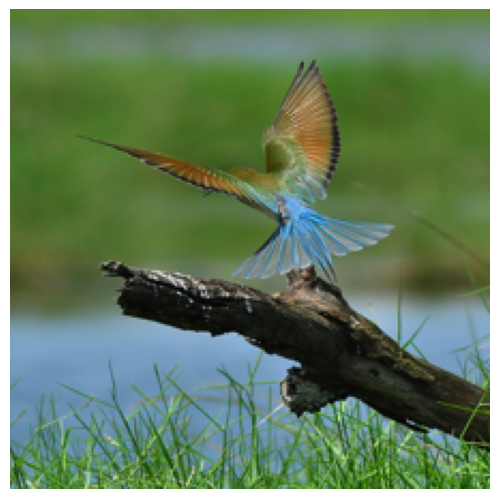

In [5]:
# image name
img='ILSVRC2012_val_00000051.JPEG'
im = utils.open_and_resize(img)

fig = plt.figure(frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(im)
plt.show()

Next lets explore the saliency map regularizing on all layers, on CPU this may take a little while to run. To run on GPU, both the model and the image need to be on GPU above.

Using cache found in /home/daniel/.cache/torch/hub/facebookresearch_dinov2_main


Target: 94


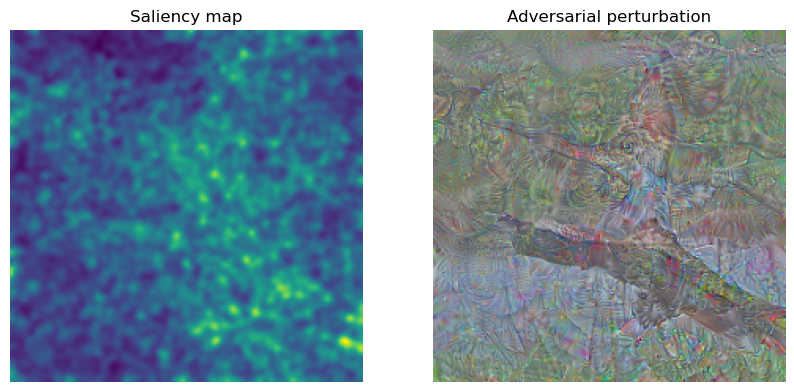

In [10]:
# layers to regularise
layerslist=["0-1-2-3-4-5-6-7-8-9-10-11-12"]

# get layers
# indexes layerAll
layers=[layerAll[int(k)] for k in layerslist[0].split('-')]

# run adversarial perturbation on the perceptual ball
adv, res = perceptual_dino(img,k=500,model=premodel,layerLists=layers,sa=0,ga=0, ds=1000, targetID=94)

# gaussian blur on image
mat1 = gaussian_filter(res, sigma=2)

# un-normalise
aim = adv[0].cpu().detach().numpy().transpose(1,2,0)
aim = (aim - aim.min())/(aim.max()-aim.min())
aim = (aim*255).astype(np.uint8)

# Plot saliency map and adversarial perturbation
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(mat1.squeeze())
ax[0].set_title('Saliency map')
ax[0].axis('off')
ax[1].imshow(aim)
ax[1].set_title('Adversarial perturbation')
ax[1].axis('off')
plt.show()

In [16]:
img_variable = utils.open_and_preprocess(img)
print(f"min, max: {img_variable.min()}, {img_variable.max()}")
response = premodel(img_variable.cuda())
target_response = response[0, 94].item()
print(f"Target response: {target_response}")
# max
response[0, 92].item()

min, max: -2.1179039478302, 2.465708017349243
Target response: 10.466181755065918


14.855831146240234

In [18]:
response = premodel(adv.cuda())
target_response = response[0, 94].item()
print(f"Target response: {target_response}")
# max
response[0, 92].item()

Target response: 623.6024169921875


280.5372619628906

In [ ]:
image_size = (952, 952)
patch_size = 14
img_variable = utils.open_and_preprocess_dino(img, image_size, patch_size)

print(img_variable.shape)

range: -2.1179039478302, 2.465708017349243
torch.Size([3, 952, 952])
torch.Size([1, 3, 952, 952])


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
for p in model.parameters():
    p.requires_grad = False
model.to(device)
model.eval()

# get the features
with torch.no_grad():
    features = model.forward_features(img_variable.to(device))


Using cache found in /home/daniel/.cache/torch/hub/facebookresearch_dinov2_main
/home/daniel/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/daniel/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/daniel/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


AttributeError: 'dict' object has no attribute 'shape'

In [25]:
clstoken = features['x_norm_clstoken']
prenorm = features['x_prenorm']
print(clstoken.shape), print(prenorm.shape)

clstoken

torch.Size([1, 384])
torch.Size([1, 4625, 384])


tensor([[-6.5285e+00,  1.4852e+00, -1.7353e+00,  3.5185e+00, -2.0524e+00,
         -3.6120e-01,  2.5254e-01, -2.7958e+00,  3.2789e+00,  2.1744e+00,
         -2.0744e+00,  2.4718e+00,  2.5347e+00, -1.5524e+00, -7.8943e-01,
          1.5619e+00, -3.8947e+00, -1.2212e+00,  6.1805e-01, -6.6051e+00,
         -9.2277e-01,  3.1353e+00, -2.5510e+00,  2.8967e+00,  4.9980e-01,
         -2.5809e+00,  3.4138e+00, -4.2785e-01,  3.7789e+00,  1.0527e+00,
          3.2601e+00, -7.0095e+00, -3.7453e+00,  6.6699e+00,  2.7753e-01,
          2.9176e+00,  1.2694e+00, -1.9961e+00,  5.9897e-01, -1.9495e+00,
         -1.8270e+00,  3.3656e+00,  5.0094e+00, -1.6117e-02, -4.3884e-01,
          2.9951e+00, -2.4995e-01,  3.7197e+00,  1.4874e+00,  2.9374e+00,
          3.6711e+00, -2.2859e+00,  2.2725e+00, -5.6114e-01,  1.5622e+00,
          1.6910e+00, -3.2448e+00, -3.4020e+00, -1.7102e+00,  2.5566e+00,
          4.1269e+00, -6.4152e-01, -1.6523e+00,  8.1807e-01,  2.5263e+00,
          5.6366e-01, -4.1235e+00,  1.

In [26]:
with torch.no_grad():
    out = model.get_intermediate_layers(img_variable.to(device))

In [29]:
out[0].shape

torch.Size([1, 4624, 384])

Finally, we run this on all of the layer sets in the paper.

We first make all of the images for each collection of layers. Note that this might take a while, expecially on CPU.

To make this runable by a wide audience we have reduced the number of LBFGS iterations and pushed the computation to CPU, which might result in slightly different results. 

In [9]:
layerslists = []
layerslists.append("")
layerslists.append("0-1-2")
layerslists.append("0-1-2-3-4")
layerslists.append("0-1-2-3-4-5-6")
layerslists.append("0-1-2-3-4-5-6-7-8-9-10-11-12")

images = []
for layerslist in layerslists:
    if len(layerslist)>0:
        layers = [layerAll[int(k)] for k in layerslist.split('-')]
    else:
        layers = []
    res = perceptual(img,k=100,model=premodel,layerLists=layers,sa=1,ga=10000)

    # gaussian blur on image
    mat1 = gaussian_filter(res, sigma=2)
    images.append(mat1)

Plot the resultant perturbations to obtain the similar plot to the version in the paper.

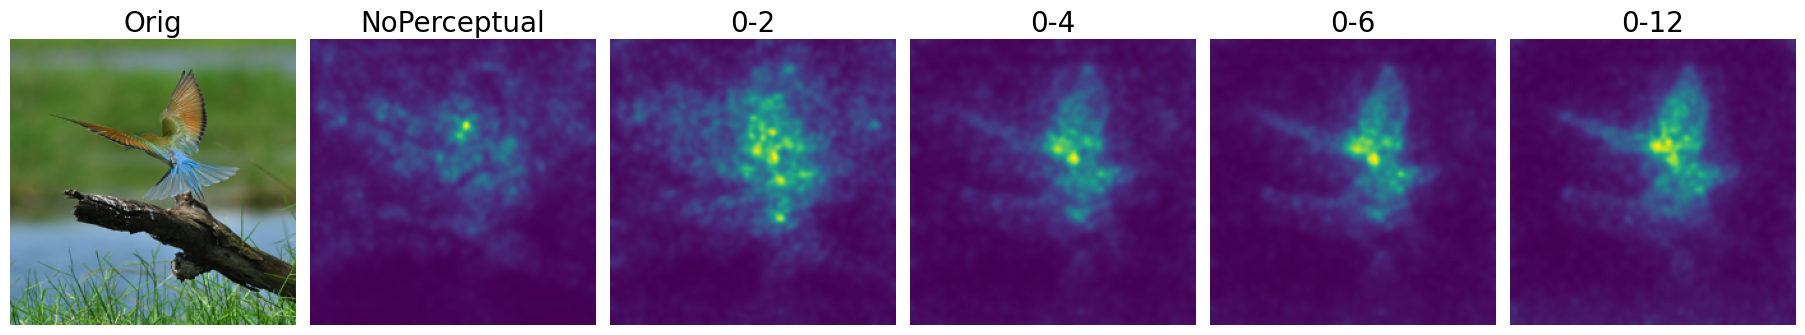

In [10]:
fig,axs = plt.subplots(1,6,figsize=(18,3))
titles = ['Orig']
titles.append("NoPerceptual")
titles.append("0-2")
titles.append("0-4")
titles.append("0-6")
titles.append("0-12")

for ax,curIm,title in zip(axs,[im,]+images,titles):
    ax.set_axis_off()
    ax.imshow(curIm)
    ax.set_title(title,fontsize=20)
plt.tight_layout(pad=0)
plt.show()